# GPU Environment Preparation

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b036a3eb-b08b-8a95-24a0-0e712e1423e6)


In [2]:
import sys
print(f"Python {sys.version}\n")

import numpy as np
print(f"NumPy {np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detected {len(gpus)} GPU(s):")
for i, gpu in enumerate(gpus):
  print(f".... GPU No. {i}: Name = {gpu.name}, Type = {gpu.device_type}")

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0, Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# Import Libraries

In [4]:
!pip install keras_retinanet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
# show images inline
%matplotlib inline

import keras
import tensorflow

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf


#Clone Git Repository
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!python setup.py build_ext --inplace

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet import models

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
/content/keras-retinanet
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


# Load Data

In [6]:
df_extrain_main = pd.read_csv("/content/_annotations.csv", header=None)
df_extrain_main.columns = ['image_path','x','y','width','height','class']
df_extrain_main.image_path = '/content/' + df_extrain_main.image_path
df_extrain_main.head()

,image_path,x,y,width,height,class
0,/content/img0006_jpg.rf.890678fd9a0cf8b6e2c248...,23,65,343,415,lazada
1,/content/img0011_jpg.rf.42f1f324140d7670fed549...,56,1,324,409,shopee
2,/content/img0004_jpg.rf.3d3c22a7ae8486fda60c78...,5,58,410,409,lazada
3,/content/img0007_jpg.rf.47a0ff33dac0fbcc0143c9...,252,53,414,416,shopee
4,/content/img0009_jpg.rf.fea004e59765be4b6d54d3...,126,4,416,415,shopee


# Creating CSV for Training

In [7]:
classes = pd.DataFrame([{'class':'lazada', 'label':0},
                        {'class':'shopee', 'label':1}])

classes.to_csv("classes.csv", index=False, header=False)  # This CSV will be use in training

df_extrain_main.to_csv("annotation.csv",index=False,header=False)

# Download Pretrained Weights

In [8]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet
import keras
import keras_resnet
import urllib.request
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-v6pscuwm
  Running command git clone -q https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-v6pscuwm
Downloaded pretrained model to ./snapshots/_pretrained_model.h5


# Training RetinaNet

In [9]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 1 --steps 500 --epochs 60 csv annotation.csv classes.csv

Creating model, this may take a second...
2022-10-17 13:08:32.116364: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)           

# Load Trained Model

In [10]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
#print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv('classes.csv',header=None).T.loc[0].to_dict()

# Predicted vs Actual

In [11]:
THRES_SCORE = 0.4  # Set Score Threshold Value

def df_plot_orinal(drawOG,img_path,df):
    df=df[df['image_path']==img_path]
    for i,r in df.iterrows():
        cv2.rectangle(drawOG, (r['x'], r['y']), (r['width'], r['height']), (255,0,0),2)
    

def img_inference(img_path):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  df_plot_orinal(drawOG,img_path,df_extrain_main)
  # correct for image scale
  boxes /= scale
  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      #print(score)
      if score < THRES_SCORE:
          continue
      color = label_color(label)
      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}%".format(labels_to_names[label], score*100)
    
  fig = plt.figure(figsize=(20, 20))
  ax1=fig.add_subplot(1, 2, 1)
  plt.imshow(draw)
  ax2=fig.add_subplot(1, 2, 2)
  plt.imshow(drawOG)

  ax1.title.set_text('Predicted')
  ax2.title.set_text('Actual')
  plt.show()

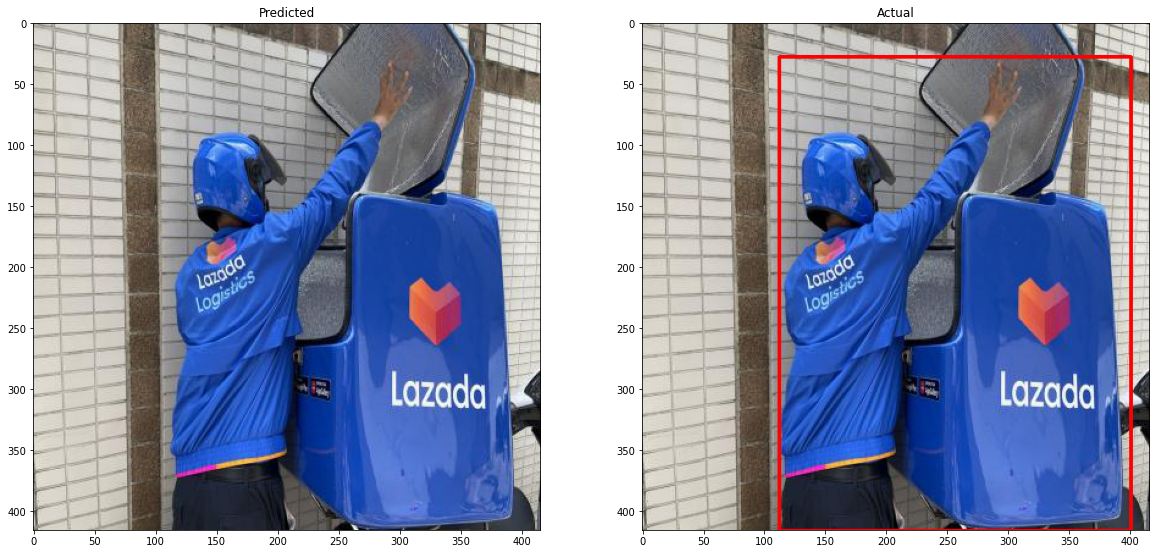

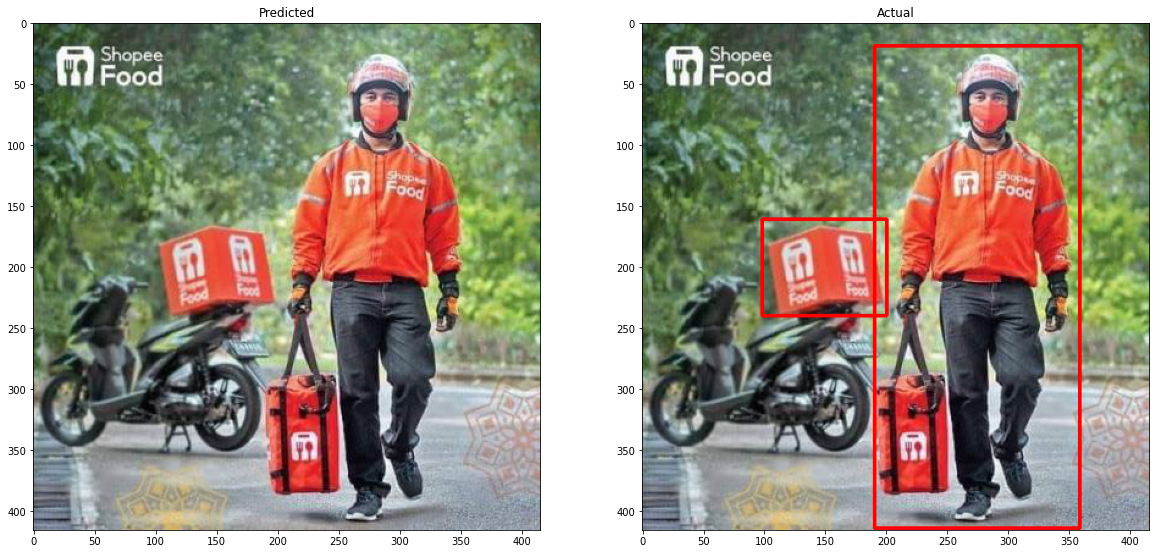

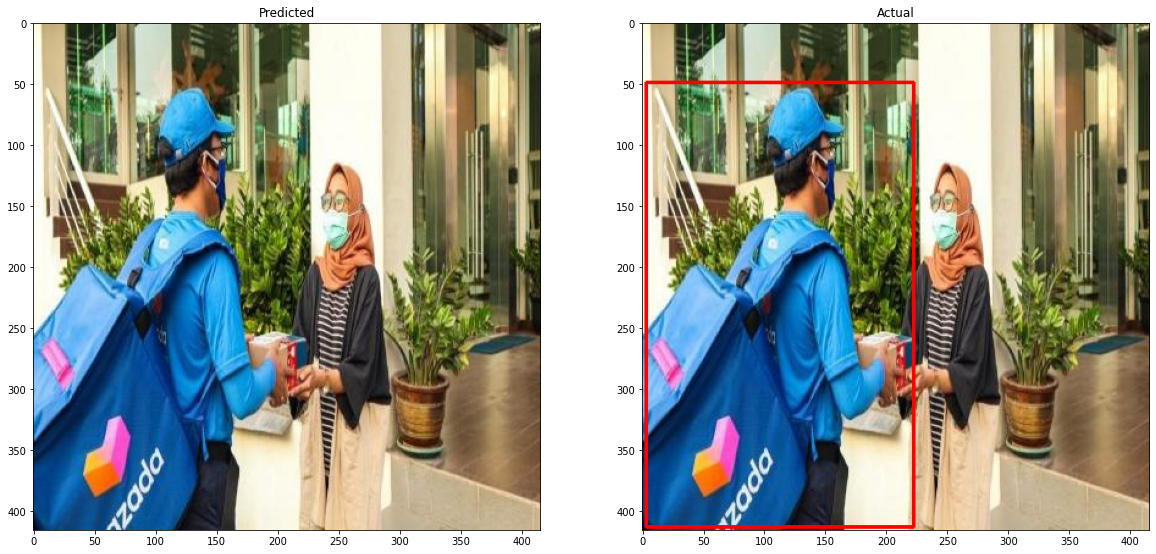

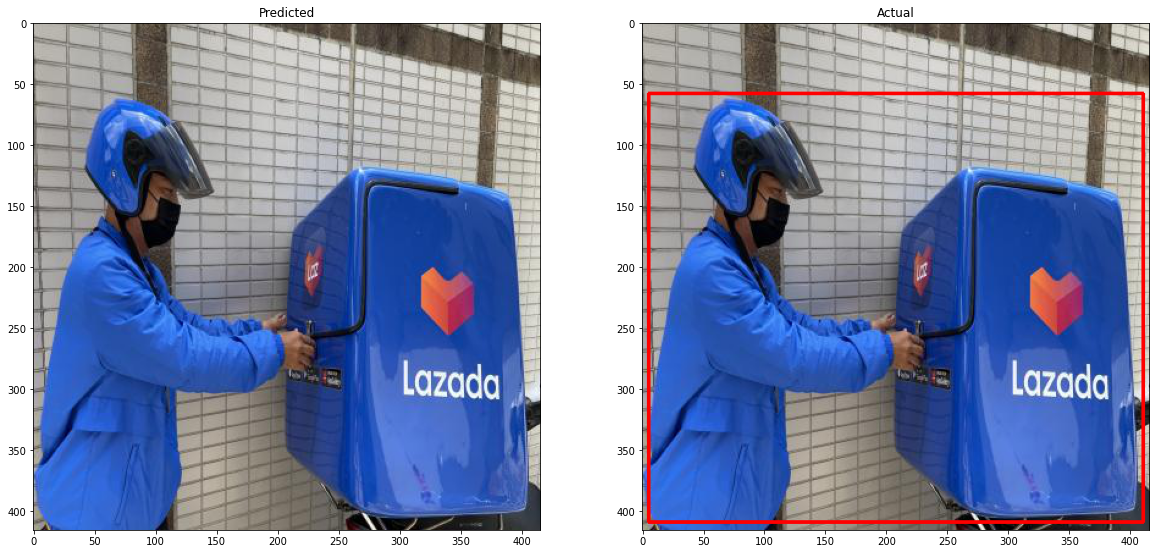

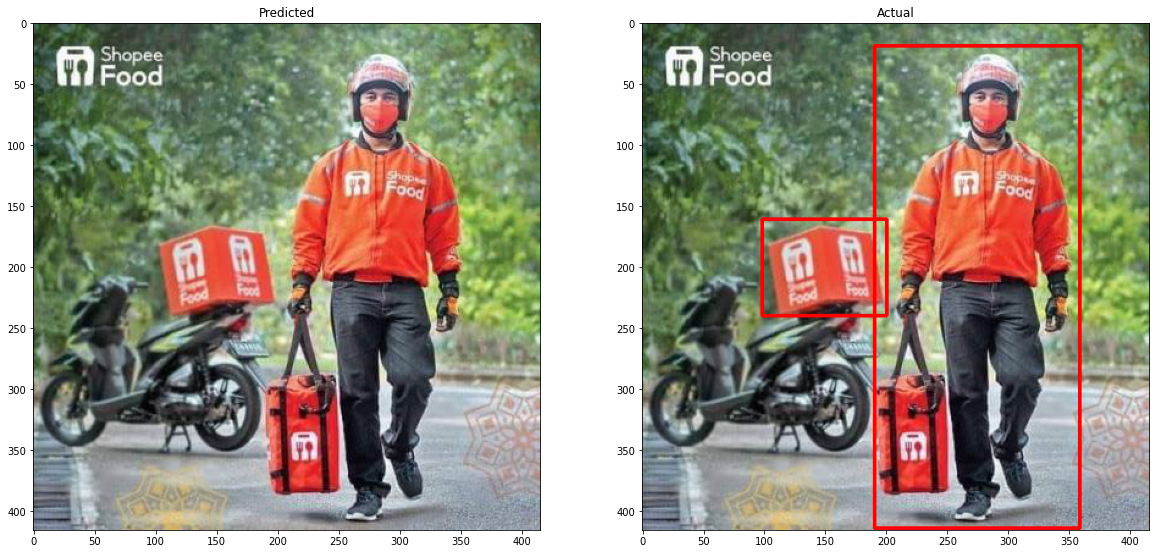

In [12]:
data=df_extrain_main.sample(n=5)  #Predict on Random 5 Image
for i,r in data.iterrows():
    img_inference(r['image_path'])